In [6]:
!pip install xgboost

In [1]:
#Import Required Libraries
import numpy as np # for efficient numerical computations
import pandas as pd # for data management
import matplotlib.pyplot as plt #to customize visualizations
import seaborn as sns #for easy/common visualizations

#Importing sklearn libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Importing xgboost
from xgboost import XGBRegressor

import warnings
warnings.simplefilter("ignore")

#Importing other required libraries
import os
import re
import csv
import operator
import random
import datetime
from datetime import datetime
import warnings

import time
import multiprocessing
import sys

# Benchmark Model

In [4]:
#Reading Training Data
dftrain = pd.read_csv('C:/Users/Jiamin_Xiao/Desktop/PTA/zillow/data/zillow-prize-1/train_2016_v2.csv')
dfprop = pd.read_csv('C:/Users/Jiamin_Xiao/Desktop/PTA/zillow/data/zillow-prize-1/properties_2016.csv')

In [ ]:
#https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error

In [4]:
def benchmark_mode():
    #Filling missing values with -1
    dfprop.fillna(-1,inplace=True)

    #Merging Datafiles
    df = pd.merge(dftrain, dfprop, on='parcelid', suffixes=('', '_r'))

    #Dropping meta columns and casting to accepted dtypes
    X = df.drop(['parcelid', 'logerror', 'transactiondate',
                 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
    for c in ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']:
        X[c] = X[c].astype('bool')

    #Applying RandomForestRegressor  
    clf = RandomForestRegressor()
    scores = model_selection.cross_val_score(clf, X, df.logerror, cv=10, scoring='neg_mean_absolute_error')
    #print("%s Accuracy: %0.5f" % (clf.__class__.__name__, scores.mean()))
    return print("%s Accuracy: %0.5f" % (clf.__class__.__name__, scores.mean()))

In [6]:
t = time.time()

benchmark_mode()

print("done in : ",time.time()-t)
print("Hah... I am done with all my work now!")

RandomForestRegressor Accuracy: -0.08231
done in :  493.5212278366089
Hah... I am done with all my work now!


# Data Preprocessing

In [5]:
#Reading Training Data
train = pd.read_csv('C:/Users/Jiamin_Xiao/Desktop/PTA/zillow/data/zillow-prize-1/train_2016_v2.csv', parse_dates=["transactiondate"])
print ("Shape Of Train: ",train.shape)
train.head()

#Reading Properties Data
prop = pd.read_csv('C:/Users/Jiamin_Xiao/Desktop/PTA/zillow/data/zillow-prize-1/properties_2016.csv')
print ("Shape Of Train: ",prop.shape)
prop.head()

#Merging both files to create the train file
train = pd.merge(train, prop, on='parcelid', how='left')
print ("Shape Of Train: ",train.shape)
train.head()

#New Variable - Exploring number of transactions in each month
train['New_transaction_month'] = train['transactiondate'].dt.month

#Dropping Columns who's %age of NaN values is greater than 70%
for col in list(train.columns.values):
    nanValues = float(train[col].isnull().sum()) / len(train)
    if nanValues > 0.70:
        #print col
        train = train.drop([col], axis=1)
        
#Corelation Analysis, dropping highly correlated variables")
for col in ('calculatedbathnbr','fullbathcnt','finishedsquarefeet12','rawcensustractandblock','censustractandblock','landtaxvaluedollarcnt','taxvaluedollarcnt'):
    train = train.drop([col], axis=1)
    
#fill median for numeric null columns
for c in train.dtypes[train.dtypes == 'float64'].index.values:
    train[c].fillna(train[c].median(), inplace = True)
    
#Imputing Null values with -1 and encoding Objects
for c in train.columns:
    train[c]=train[c].fillna(-1)
    if train[c].dtype == object:
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values))
        train[c] = lbl.transform(list(train[c].values))
         
#Dropping out outliers
train=train[ train.logerror > -0.417 ]
train=train[ train.logerror < 0.418 ]

#Processing data
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

#Splitting logerror as test data
test = train.logerror

#Dropping meta columns and casting to accepted dtypes
train = train.drop(['parcelid', 'logerror', 'transactiondate',
                'propertyzoningdesc', 'propertycountylandusecode'], axis=1)   

Shape Of Train:  (90275, 3)
Shape Of Train:  (2985217, 58)
Shape Of Train:  (90275, 60)


# Feature Engineering

In [6]:
#Adding new features

#proportion of living area
train['New_LivingAreaProp'] = train['calculatedfinishedsquarefeet']/train['lotsizesquarefeet']

#Number of properties in the zip
zip_count = train['regionidzip'].value_counts().to_dict()
train['New_zip_count'] = train['regionidzip'].map(zip_count)

#Number of properties in the city
city_count = train['regionidcity'].value_counts().to_dict()
train['New_city_count'] = train['regionidcity'].map(city_count)

# Model Selection

In [7]:
#Printing out all the Variables
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]

#Testing various Regression models
allModels = {} # Dictionary of models and their respective losses

In [8]:
print("Running XGB Regression")
model = XGBRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

Running XGB Regression


In [7]:
print("Running Linear Regression")
model = linear_model.LinearRegression()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

Running Linear Regression


In [8]:
print("Running Bayesian Ridge Regression")
model = linear_model.BayesianRidge()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

Running Bayesian Ridge Regression


In [9]:
print("Running Ridge Regression")
model = linear_model.Ridge()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

Running Ridge Regression


In [10]:
print("Running Lasso Regression")
model = linear_model.Lasso()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

Running Lasso Regression


In [11]:
print("Running Decision Trees")
model = tree.DecisionTreeRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

Running Decision Trees


In [12]:
print("Running Random Forest")
model = RandomForestRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

Running Random Forest


In [13]:
print("Running KNN")
model = KNeighborsRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

Running KNN


In [14]:
print("Running Gradient Boosted Regressor")
model = GradientBoostingRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

Running Gradient Boosted Regressor


In [15]:
print("Returning the best model")
sortedModels = sorted(allModels.items(), key=operator.itemgetter(1), reverse=True)
for model in sortedModels:
    print ('Model:', model[0])
    print ('Loss:', model[1])

Returning the best model
Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Loss: -0.053039984032511714
Model: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start

# Cross Validation and Feature Importances

Cross validation again using best estimated parameters
Printing Final Score
MAE: 0.05 (+/- 0.00)


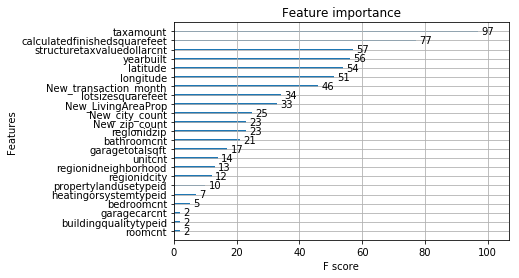

In [9]:
#Importing xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

print("Cross validation again using best estimated parameters")
clf = XGBRegressor(learning_rate =0.1,max_depth= 3,min_child_weight=1,n_estimators=100)
scores = model_selection.cross_val_score(clf, train, test, cv=10,  scoring='neg_mean_absolute_error')
print("Printing Final Score")
print("MAE: %0.2f (+/- %0.2f)" % (abs(scores.mean()), scores.std()*2))

clf.fit(train, test)  
#print("Printing Feature Importances")
#print (clf.feature_importances_)
#plt.bar(range(len(clf.feature_importances_)),clf.feature_importances_)
#plt.show()

plot_importance(clf)
plt.show()